In [1]:
import pandas as pd

df = pd.read_csv("../data/mqm_generalMT2022_ende.mqm.tsv", sep="\t")
df["domain"] = df["doc"].apply(lambda x: x.split(".")[0].split("_")[0])
category_counts = dict(df["domain"].value_counts())

In [2]:
from collections import Counter
def get_mqm_score(row):
  if row["severity"] == "No-error":
    return 100
  else:
    error_list = row["severity"].split(",")
    error_count = Counter(error_list)
    mqm = 100 - (error_count["minor"] + 5*error_count["major"])/(len(row["target"].split(" "))*100)
  return mqm

df["mqm"] = df.apply(lambda x: get_mqm_score(x), axis=1)


In [3]:
df["cua"] = pd.cut(df['mqm'], [0, 39, 59, 79, 100], labels=["weak", "moderate", "good", "excellent"])

In [4]:
count_no_error = {}
for group_name, group_df in df.groupby(["domain"]):
  count_no_error[group_name] = len(group_df[group_df.category  == "No-error"]) / len(group_df)

In [7]:
count_no_error

{('conversation',): 0.5783707865168539,
 ('ecommerce',): 0.589945652173913,
 ('news',): 0.46375,
 ('social',): 0.5009191176470589}

In [5]:
df["src_len"] = df["source"].apply(lambda x: len(x.split(" ")))

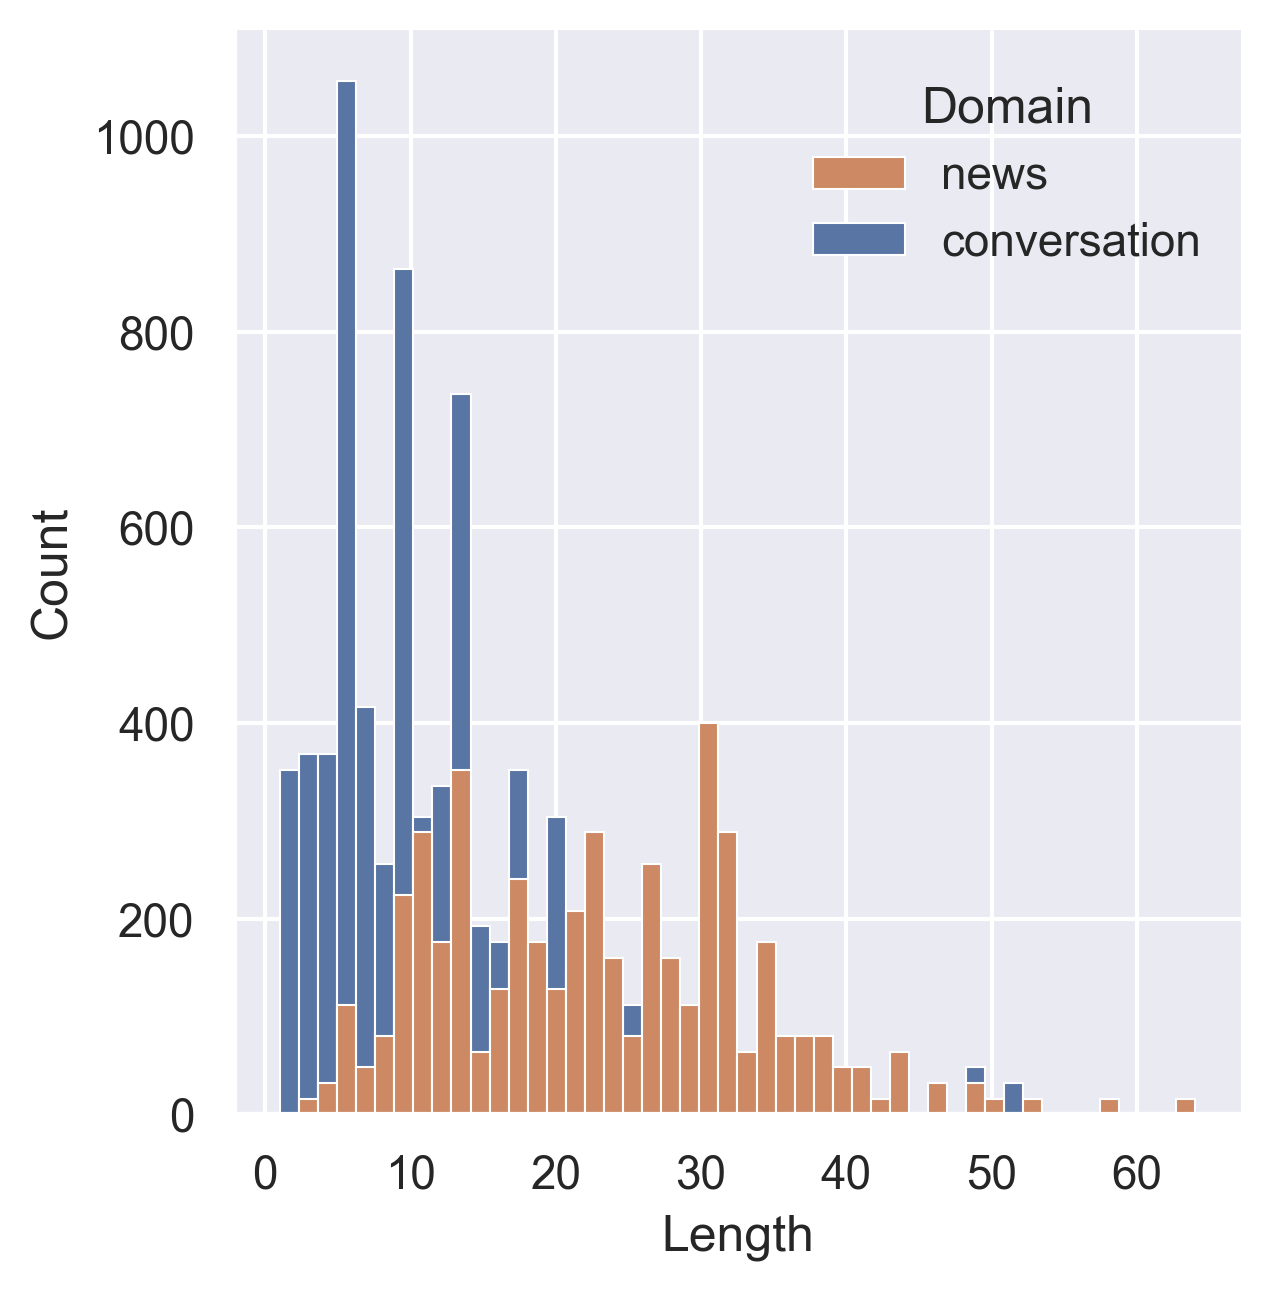

In [6]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set_theme()
font = {'size'   : 30}
mpl.rc('font', **font)
mpl.rcParams['figure.dpi'] = 300
with sns.axes_style("darkgrid"):
  g = sns.displot(x="src_len", data=df[df.domain.isin(["conversation", "news"])], hue="domain", linewidth=0.5, palette=[  "#cc8963", "#5975a4"], alpha=1)
  sns.move_legend(g, "upper right", bbox_to_anchor=(.70, .90), title='Domain')
  g.set(xlabel='Length', ylabel='Count')

In [15]:
df.head()

,system,doc,doc_id,seg_id,rater,source,target,category,severity,start,end,error,domain,mqm,cua,src_len
0,Online-B,news_stv.tv.1681:English-German,1,956,rater1,Warning of stormy weather as strong winds pres...,"Warnung vor stürmischem Wetter, da starke Wind...",No-error,No-error,NaN,NaN,NaN,news,100.000000,excellent,11
1,Online-B,news_stv.tv.1681:English-German,2,957,rater1,Storm force winds are set to batter northern p...,Sturmböen werden nördliche Teile Schottlands t...,No-error,No-error,NaN,NaN,NaN,news,100.000000,excellent,19
2,Online-B,news_stv.tv.1681:English-German,3,958,rater1,"The northwest, Shetland and Orkney will face g...","Der Nordwesten, Shetland und Orkney werden von...",Fluency/Punctuation,minor,36,42,werden,news,99.999565,excellent,18
3,Online-B,news_stv.tv.1681:English-German,4,959,rater1,"The Hebrides, and western coast of the Highlan...",Die Hebriden und die Westküste der Highlands s...,No-error,No-error,NaN,NaN,NaN,news,100.000000,excellent,33
4,Online-B,news_stv.tv.1681:English-German,5,960,rater1,Experts are warning that the bad weather could...,"Experten warnen davor, dass das schlechte Wett...",No-error,No-error,NaN,NaN,NaN,news,100.000000,excellent,23


In [28]:
errors_all_domains = {}
for group_name, group_df in df.groupby(["domain"]):
  if group_name[0] in ["conversation","news"]:
    error_counter = {}
    for i, row in group_df.iterrows():
      if isinstance(row["category"], str):
        error_list = row["category"].split(",")
        for error in error_list:
          if error not in error_counter:
            error_counter[error] = 1
          else:
            error_counter[error] += 1
      errors_all_domains[group_name[0]] = error_counter

In [30]:
df_new = pd.DataFrame(errors_all_domains).reset_index().rename(columns={"index": "Error Type"}).melt('Error Type', var_name='Domain', value_name='Count')

In [31]:
df_T = pd.DataFrame(errors_all_domains).T.reset_index().rename(columns={"index":"Domain"})
df_T.fillna(0, inplace=True)
for column in df_T.columns:
  if column!="Domain" and len(df_T[column])==2:
    value_dict = dict(zip(df_T.Domain, df_T[column]))
    value_dict_norm = {key: val/category_counts[key] for key, val in value_dict.items()}
    domain_max = max(value_dict_norm, key=lambda k: value_dict_norm.get(k))
    if domain_max == "conversation":
      print(column)

No-error
Terminology/Inconsistent
Fluency/Register
Fluency/Spelling
Fluency/Inconsistency
Source error


In [33]:
df_new["Count (norm)"] = df_new.apply(lambda x: x["Count"]/category_counts[x["Domain"]], axis=1)

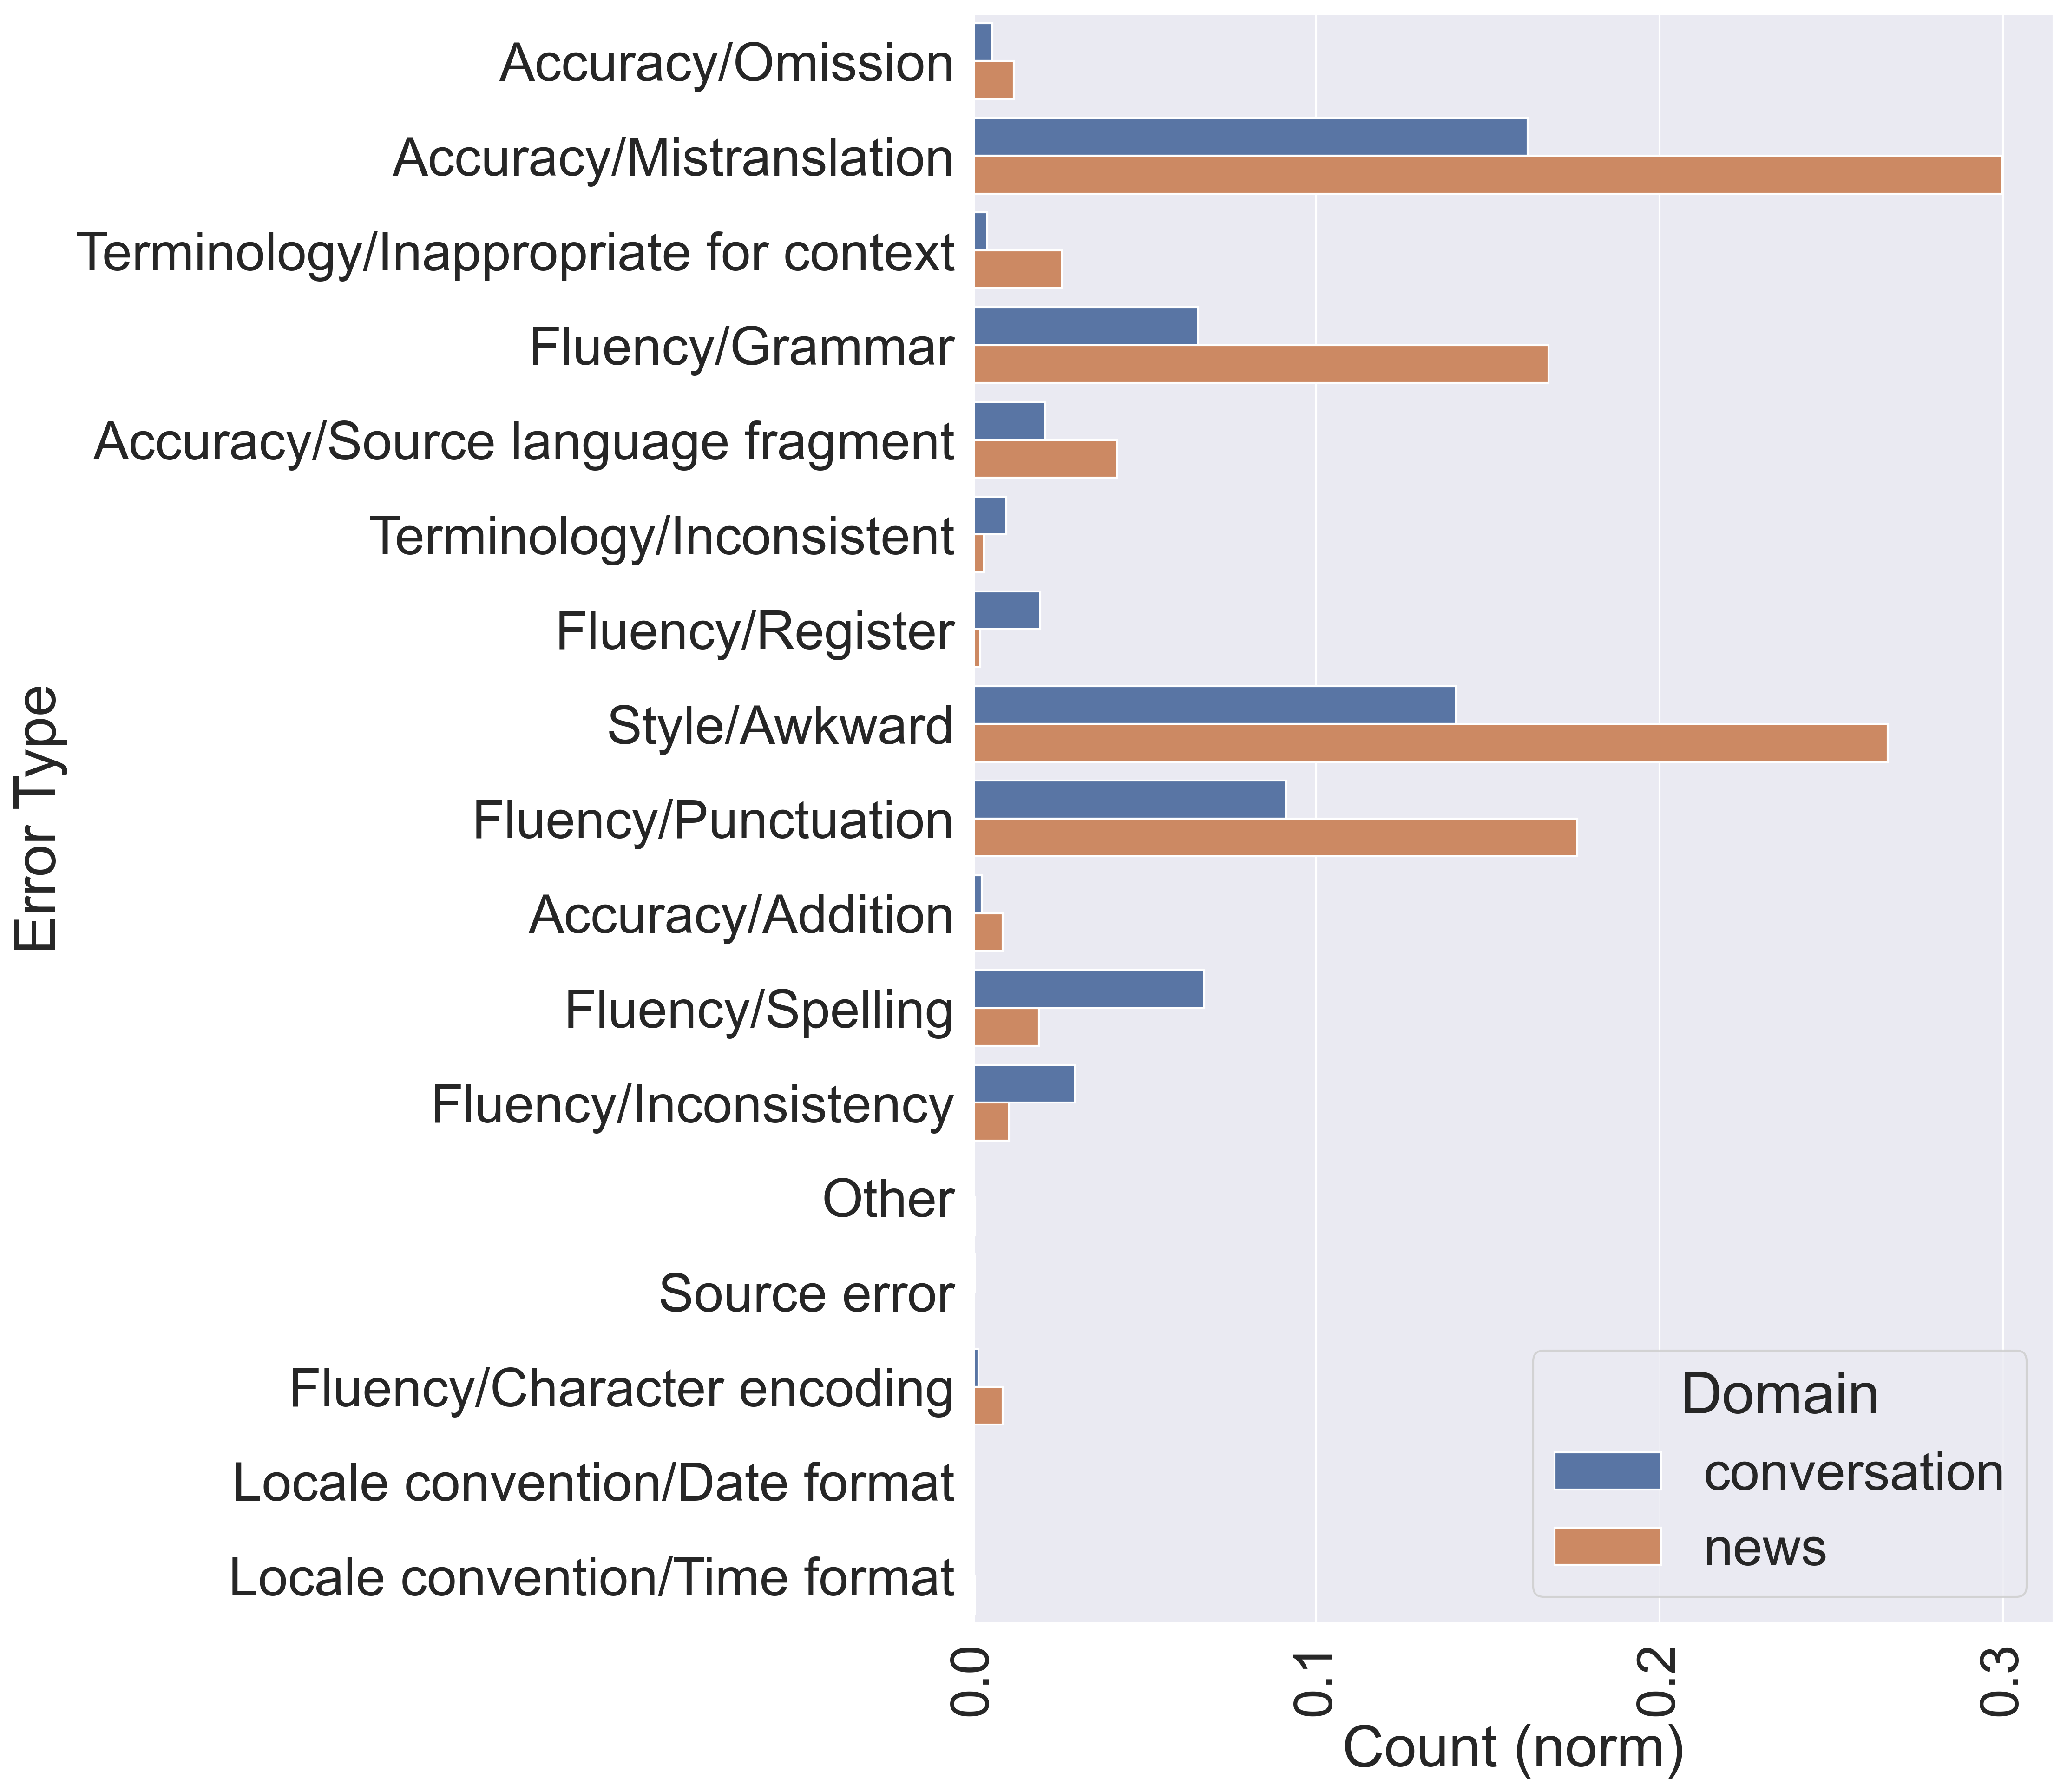

In [34]:
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
sns.set(rc = {'figure.figsize':(10,15)})
sns.set(font_scale=2.5)
# mpl.rcParams['figure.dpi']= 300
sns.barplot(df_new[df_new["Error Type"]!="No-error"], x="Count (norm)", y="Error Type", hue="Domain", orient = 'h')
plt.xticks(rotation=90)
plt.legend(loc='lower right',title="Domain")